An analysis of a dataset concerning malignant mesothelioma, an agressive tumor of pleura connected to asbestos exposure. 

Link to the dataset: https://archive.ics.uci.edu/ml/datasets/Mesothelioma%C3%A2%E2%82%AC%E2%84%A2s+disease+data+set+#



In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
data = pd.read_csv('data.csv').drop('diagnosis method', axis=1)
print('{} patients, {} features'.format(*data.shape))
# diagnosis method dropped because it is a duplicate of class of diagnosis

324 patients, 34 features


# Checking for missing values

In [3]:
data.isnull().any()

age                                 False
gender                              False
city                                False
asbestos exposure                   False
type of MM                          False
duration of asbestos exposure       False
keep side                           False
cytology                            False
duration of symptoms                False
dyspnoea                            False
ache on chest                       False
weakness                            False
habit of cigarette                  False
performance status                  False
white blood                         False
cell count (WBC)                    False
hemoglobin (HGB)                    False
platelet count (PLT)                False
sedimentation                       False
blood lactic dehydrogenise (LDH)    False
alkaline phosphatise (ALP)          False
total protein                       False
albumin                             False
glucose                           

# Frequencies of categorical variables

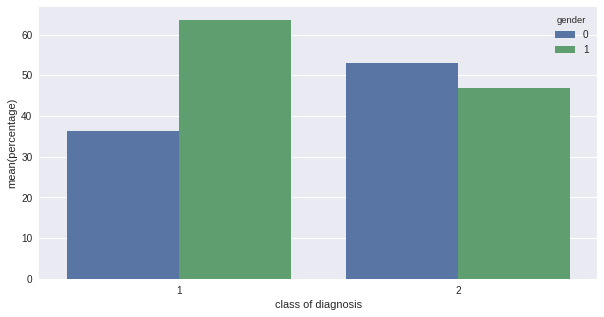

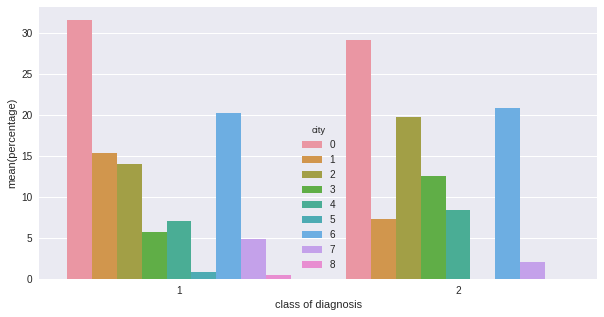

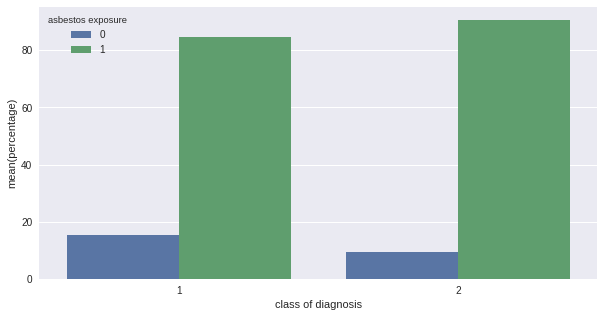

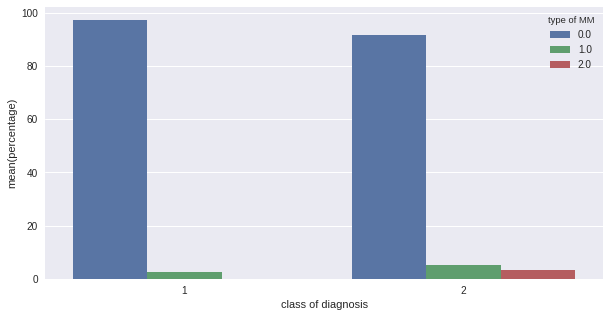

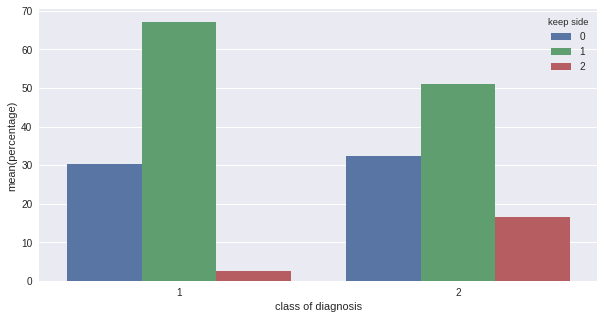

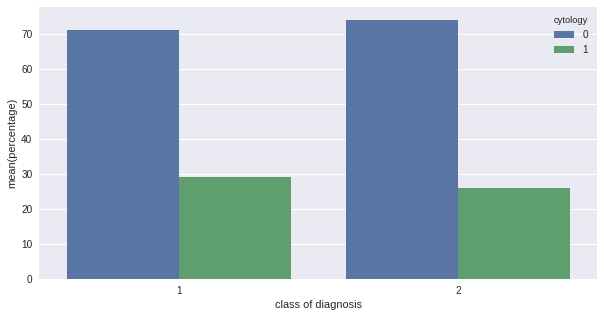

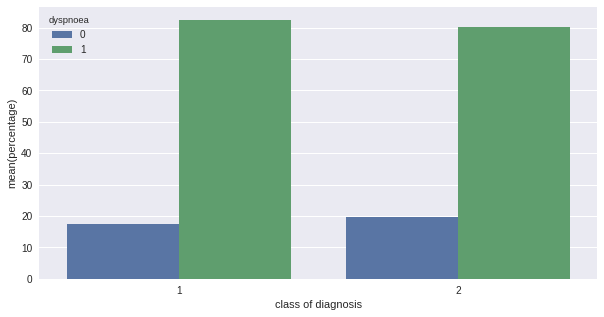

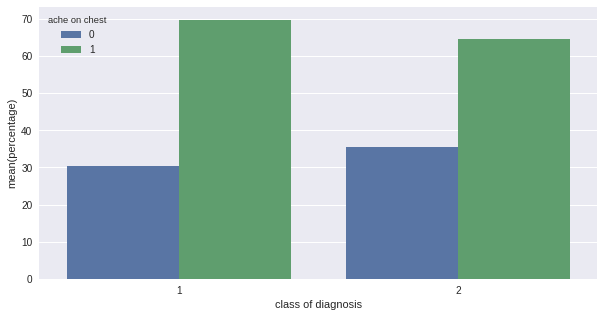

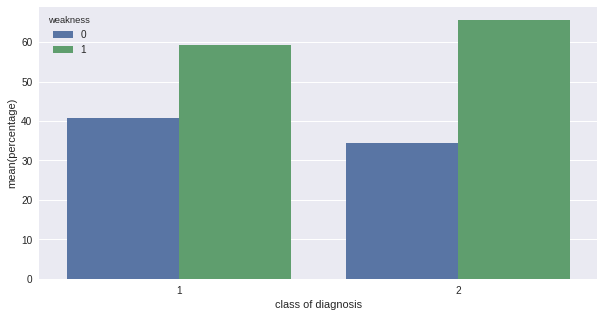

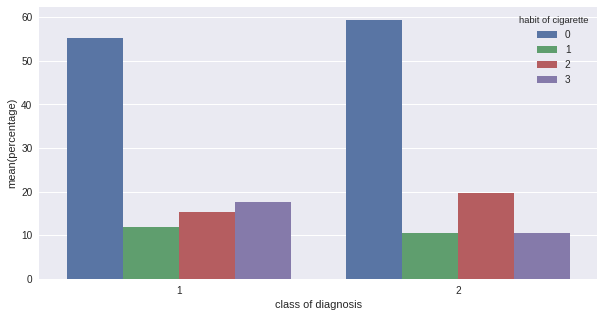

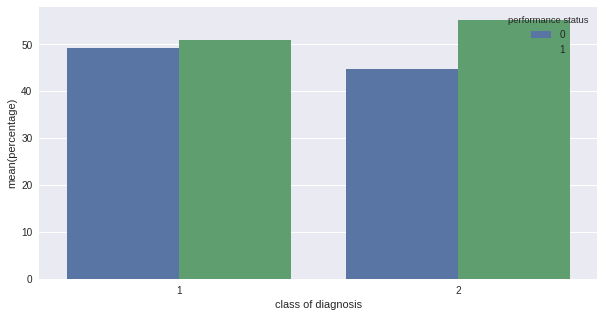

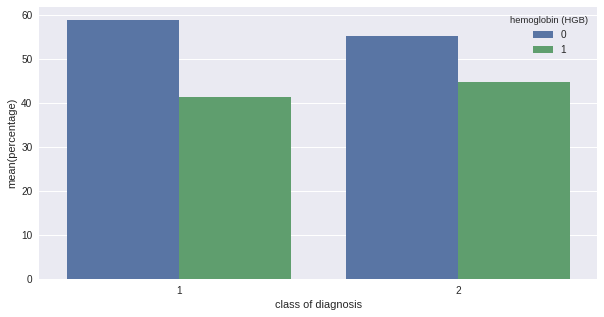

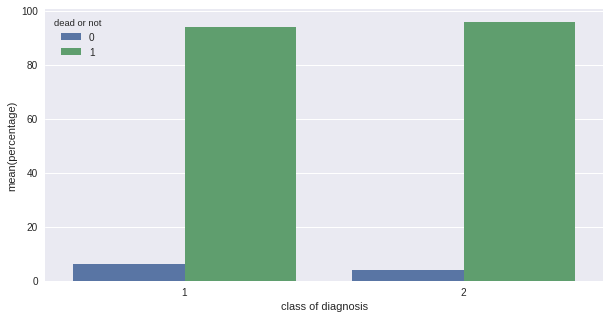

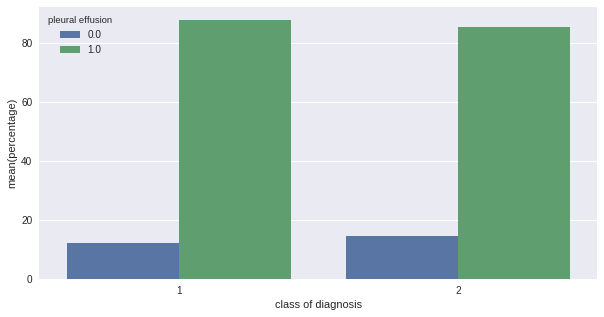

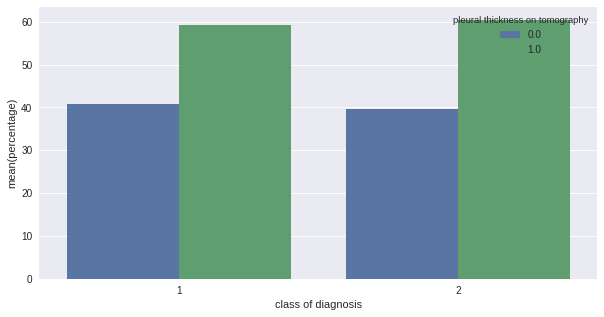

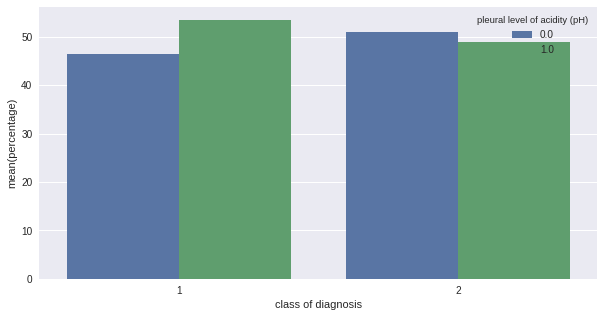

In [4]:
categoricals = data.ix[:, data.apply(lambda x: x.nunique()) < 10]

for col in categoricals.drop('class of diagnosis', axis=1):
    counts = (categoricals.groupby(['class of diagnosis'])[col]
                         .value_counts(normalize=True)
                         .rename('percentage')
                         .mul(100)
                         .reset_index())
    plt.figure(figsize=(10,5))
    p = sns.barplot(x='class of diagnosis', y="percentage", hue=col, data=counts)

# Distributions of continous variables

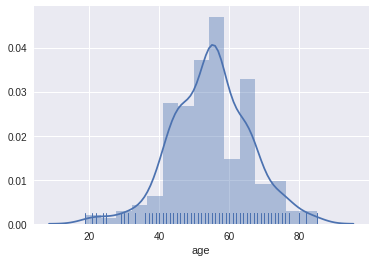

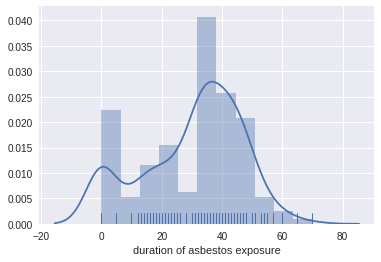

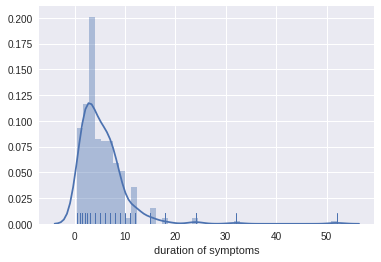

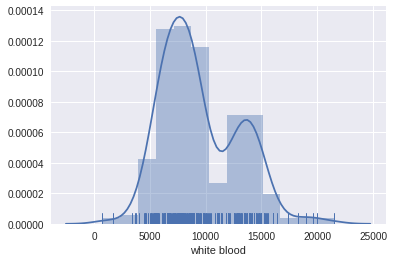

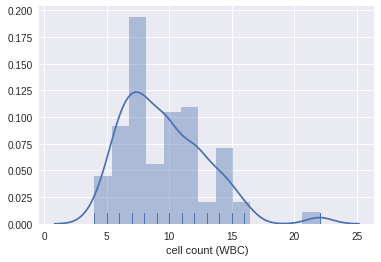

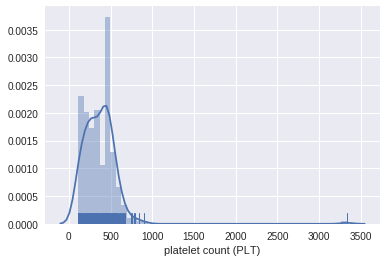

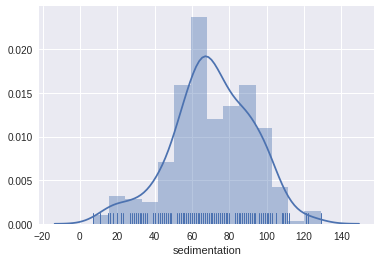

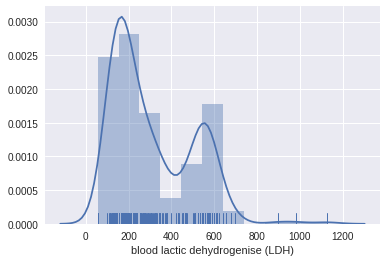

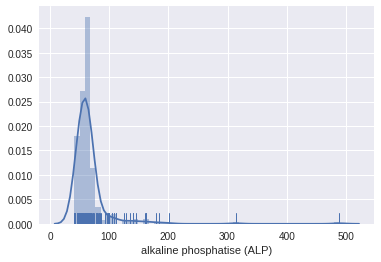

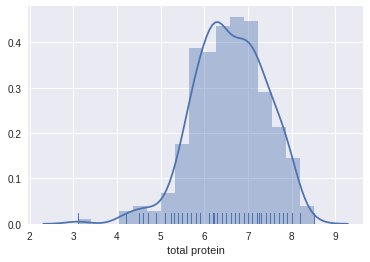

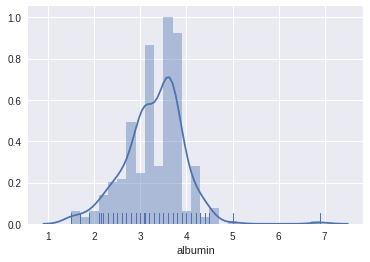

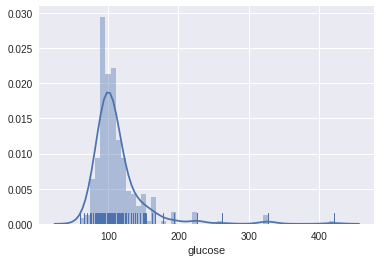

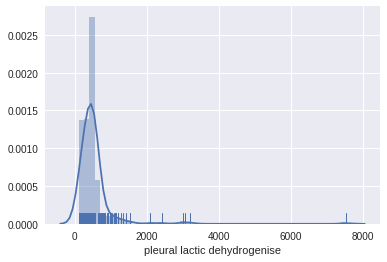

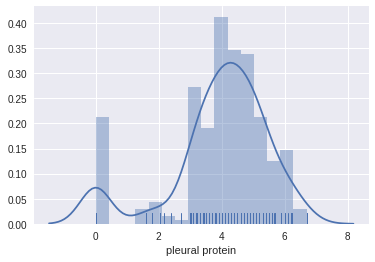

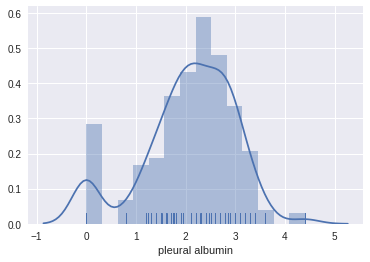

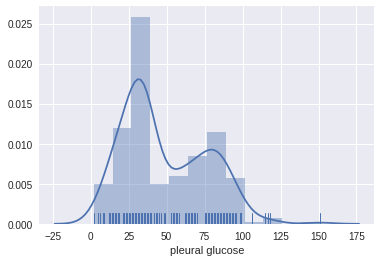

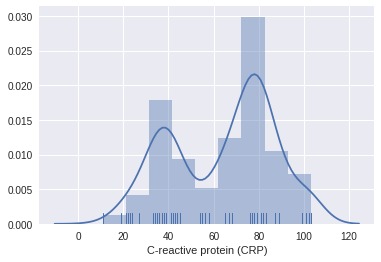

In [5]:
continuous = data.drop(categoricals.columns, axis=1)
for col in continuous:
    plt.figure()
    sns.distplot(continuous[col], rug=True)

        

# Distributions split by target values

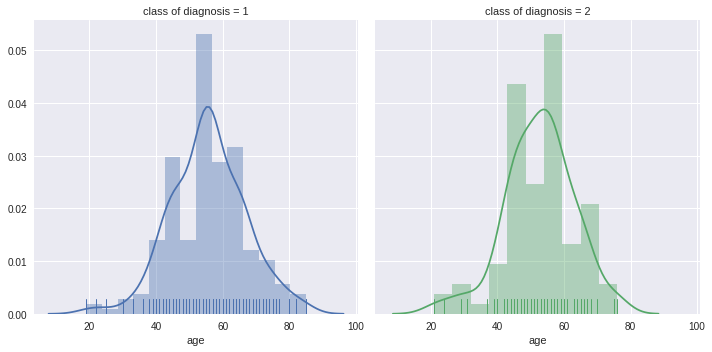

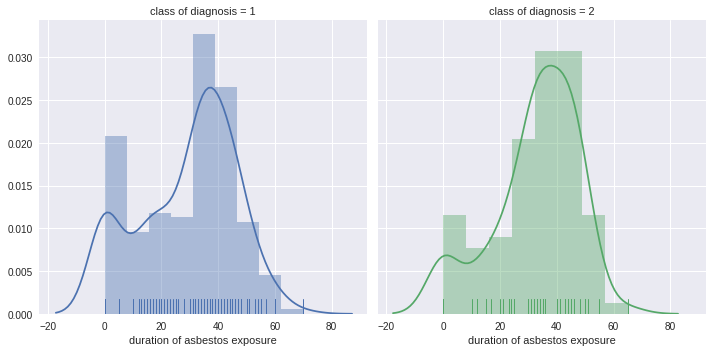

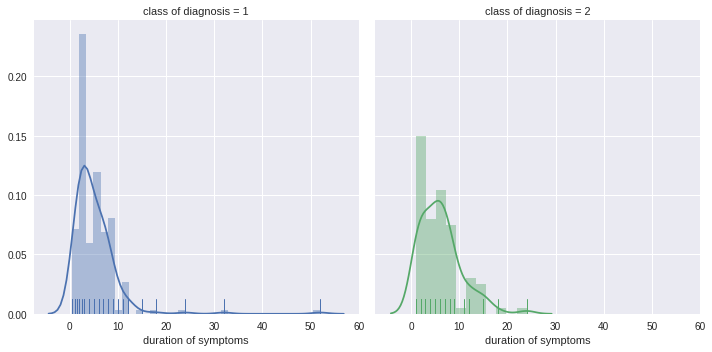

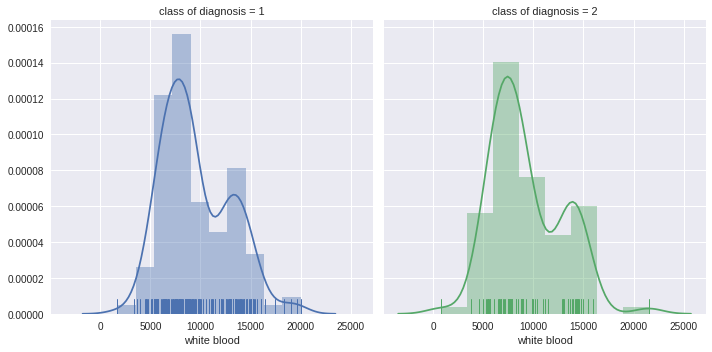

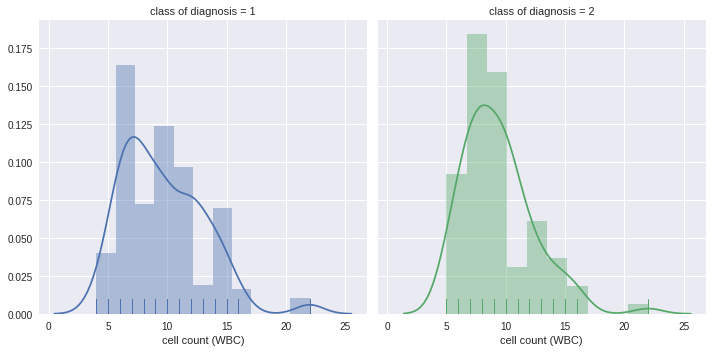

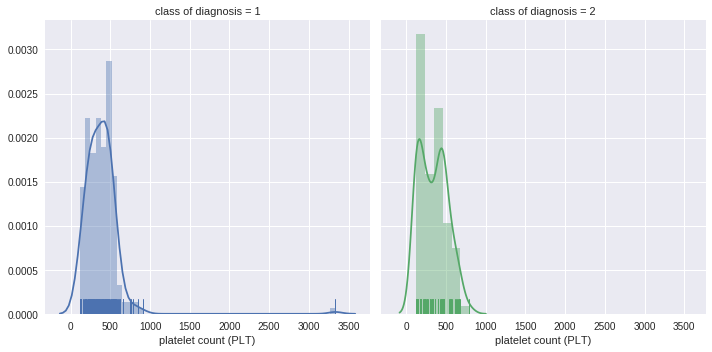

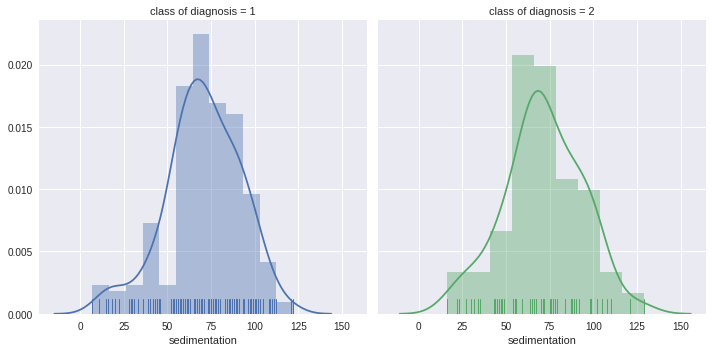

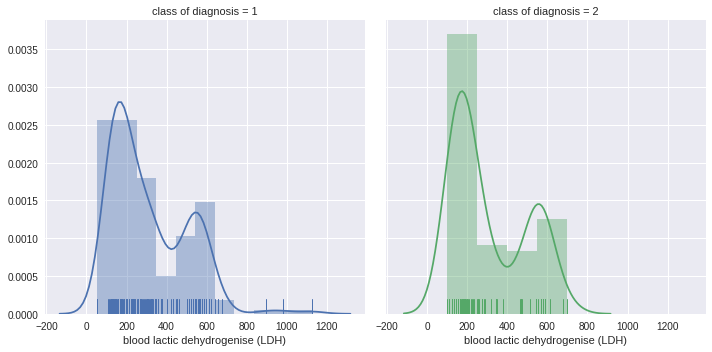

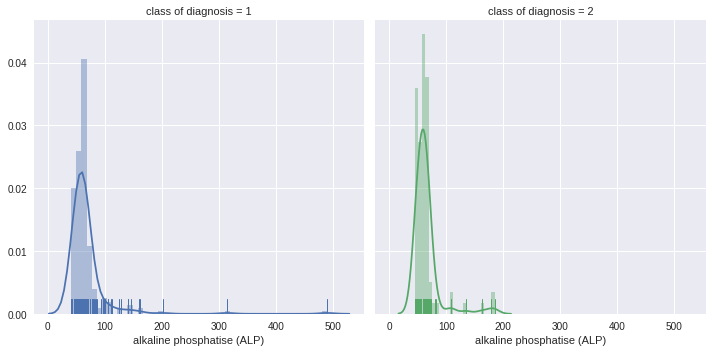

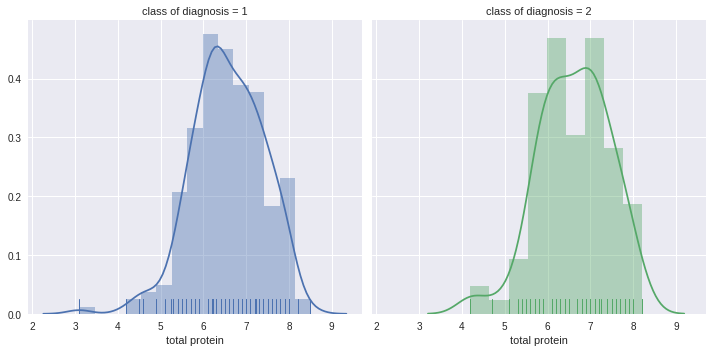

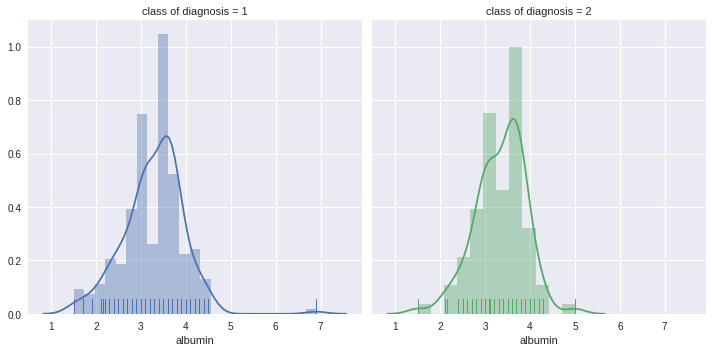

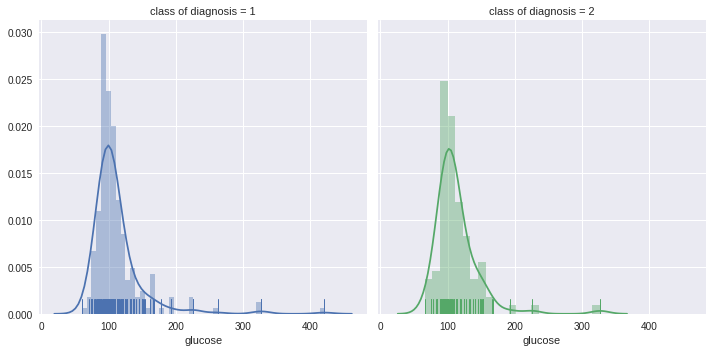

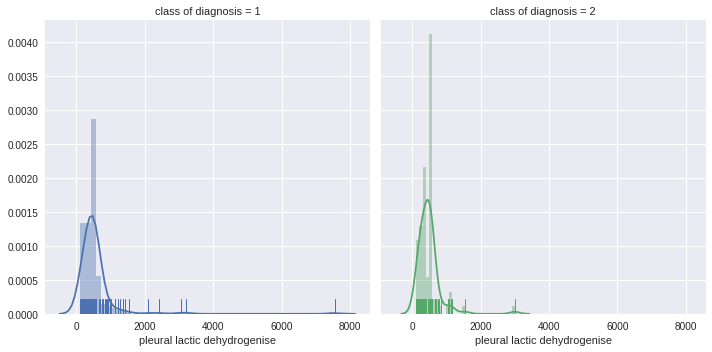

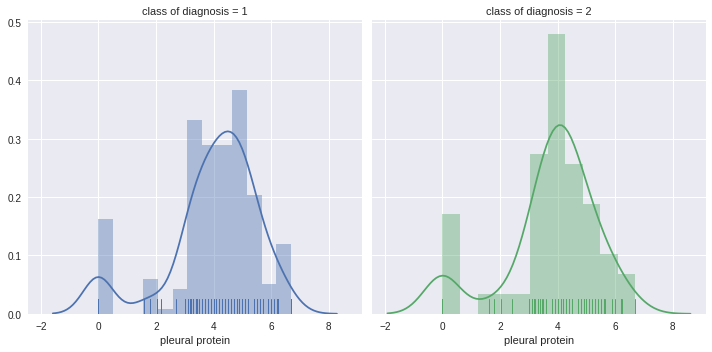

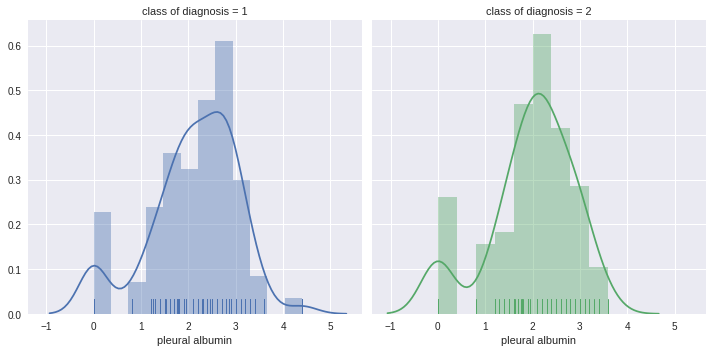

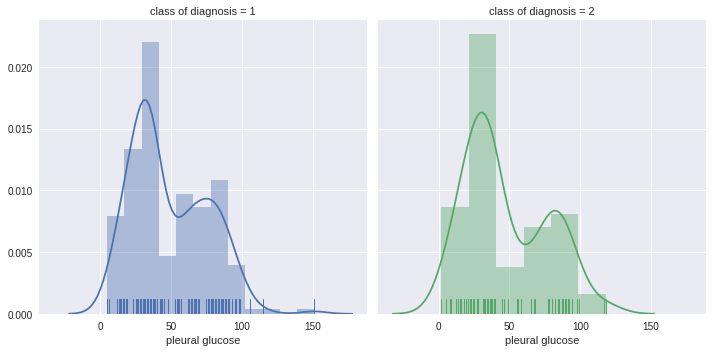

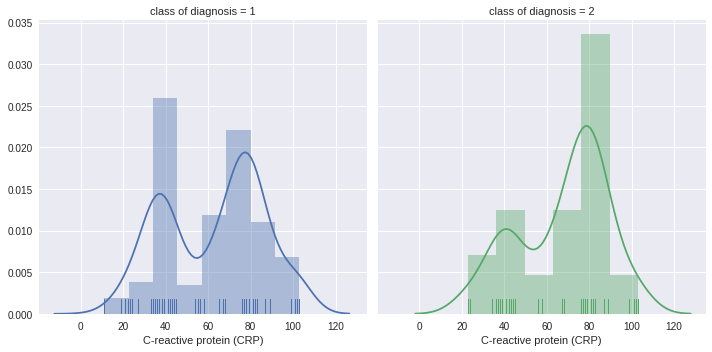

In [6]:
conc = pd.concat([continuous, data['class of diagnosis']], axis=1)
for col in continuous:
    g=sns.FacetGrid(size=5,data=conc, col='class of diagnosis', hue='class of diagnosis')
    g.map(sns.distplot, col ,rug=True, kde=True)


In [7]:
conc.groupby('class of diagnosis').describe()

C-reactive protein (CRP)         age     albumin  \
class of diagnosis                                                           
1                  count                228.000000  228.000000  228.000000   
                   mean                  62.635965   55.631579    3.283114   
                   std                   23.280211   11.173650    0.665297   
                   min                   11.000000   19.000000    1.500000   
                   25%                   39.000000   47.750000    2.975000   
                   50%                   67.000000   56.000000    3.400000   
                   75%                   78.250000   63.250000    3.700000   
                   max                  103.000000   85.000000    6.900000   
2                  count                 96.000000   96.000000   96.000000   
                   mean                  67.875000   52.635417    3.343958   
                   std                   20.774098   10.338604    0.555839   
                   min                   23.000000   21.000000    1.500000   
                   25%                   45.000000   46.000000    3.000000   
                   50%                   77.000000   54.000000    3.500000   
                   75%                   81.000000   59.000000    3.700000   
                   max                  103.000000   76.000000    5.000000   

                          alkaline phosphatise (ALP)  \
class of diagnosis                                     
1                  count                  228.000000   
                   mean                    66.811404   
                   std                     38.863643   
                   min                     41.000000   
                   25%                     52.000000   
                   50%                     62.000000   
                   75%                     66.000000   
                   max                    489.000000   
2                  count                   96.000000   
                   mean                    64.625000   
                   std                     23.892853   
                   min                     45.000000   
                   25%                     52.000000   
                   50%                     61.500000   
                   75%                     66.000000   
                   max                    185.000000   

                          blood lactic dehydrogenise (LDH)  cell count (WBC)  \
class of diagnosis                                                             
1                  count                        228.000000        228.000000   
                   mean                         310.315789          9.644737   
                   std                          187.047442          3.485795   
                   min                           55.000000          4.000000   
                   25%                          151.750000          7.000000   
                   50%                          246.500000          9.000000   
                   75%                          472.000000         12.000000   
                   max                         1128.000000         22.000000   
2                  count                         96.000000         96.000000   
                   mean                         305.583333          9.354167   
                   std                          181.466057          2.998172   
                   min                          101.000000          5.000000   
                   25%                          156.000000          7.000000   
                   50%                          206.500000          9.000000   
                   75%                          543.250000         11.000000   
                   max                          698.000000         22.000000   

                          duration of asbestos exposure  duration of symptoms  \
class of diagnosis                                                              
1        

# Correlated variables

In [8]:
"Correlation"
corr_threshold = 0.3
corr_matrix = continuous.corr()
find_corr = lambda x: corr_matrix[x][corr_matrix[x].index != x][abs(corr_matrix[x]) > corr_threshold].index.tolist()
corr = {col : find_corr(col) for col in corr_matrix}

print("These have absolute correlation of {}% or more:".format(corr_threshold*100)) # * 100 to get percentage

for key in corr.keys():
    if len(corr[key]) > 0: 
        print("\n{}:\n".format(key), end="")
        for correlated in corr[key]:
            print("-{} ({})".format(correlated, round(corr_matrix[key][correlated] * 100)))

These have absolute correlation of 30.0% or more:

age:
-duration of asbestos exposure (33.0)

pleural lactic dehydrogenise:
-pleural glucose (-31.0)

pleural albumin:
-pleural protein (91.0)

platelet count (PLT):
-blood lactic dehydrogenise (LDH) (34.0)

pleural protein:
-pleural albumin (91.0)
-pleural glucose (-30.0)

duration of asbestos exposure:
-age (33.0)

pleural glucose:
-blood lactic dehydrogenise (LDH) (-46.0)
-pleural lactic dehydrogenise (-31.0)
-pleural protein (-30.0)
-C-reactive protein (CRP) (-41.0)

C-reactive protein (CRP):
-pleural glucose (-41.0)

total protein:
-albumin (42.0)

albumin:
-total protein (42.0)

blood lactic dehydrogenise (LDH):
-platelet count (PLT) (34.0)
-pleural glucose (-46.0)


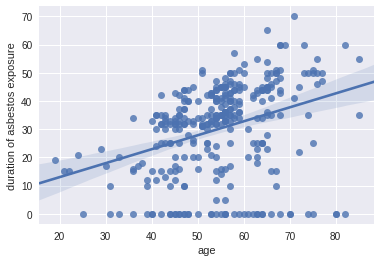

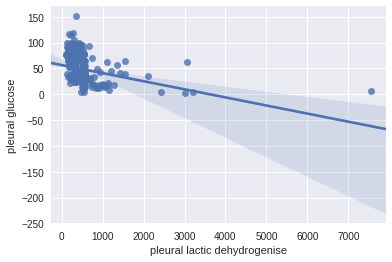

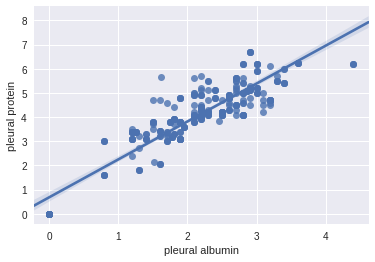

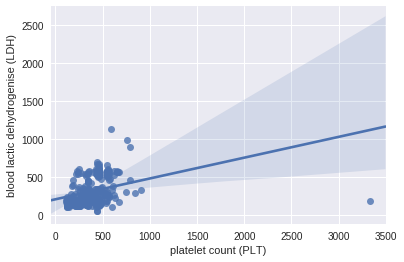

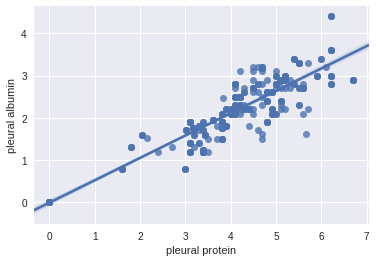

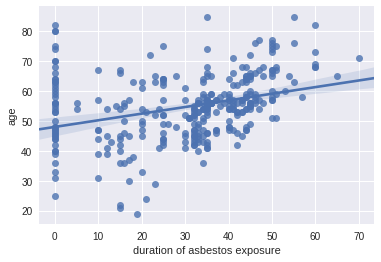

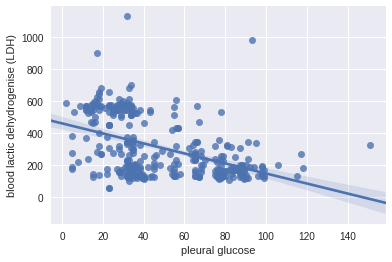

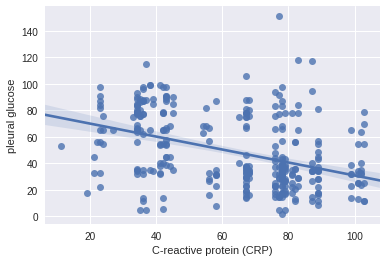

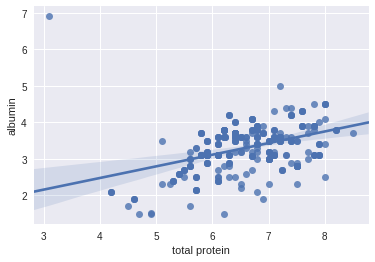

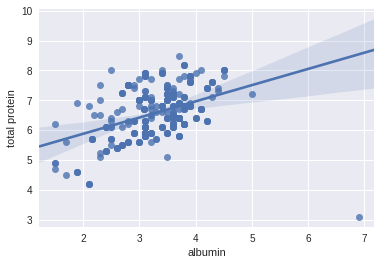

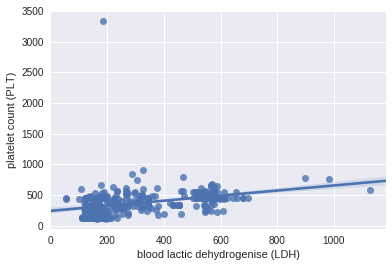

In [9]:
for feature in corr:
    if corr[feature]:
        plt.figure()
        sns.regplot(data=continuous, x=feature, y=corr[feature][0], fit_reg=True)

# One-hot encoding and scaling

In [10]:
categoricals_BIN_names = ["gender", "asbestos exposure", # "diagnosis method", 
                          "cytology", "dyspnoea", "ache on chest", "weakness",
                          "performance status", "hemoglobin (HGB)", "dead or not",
                          "pleural effusion", "pleural thickness on tomography", "pleural level of acidity (pH)"]

categoricals_non_BIN_names = ["city", "type of MM", "keep side", "habit of cigarette"]

categoricals_names = ["city", "type of MM", "keep side", "habit of cigarette", 
                      "gender", "asbestos exposure", "diagnosis method", 
                      "cytology", "dyspnoea", "ache on chest", "weakness",
                      "performance status", "hemoglobin (HGB)", "dead or not",
                      "pleural effusion", "pleural thickness on tomography", 
                      "pleural level of acidity (pH)"]

categorical_binary = data[categoricals_BIN_names]
categorical_non_binary = data[categoricals_non_BIN_names]

In [11]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse=False)
onehot_X = enc.fit_transform(categorical_non_binary)


In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_cont = scaler.fit_transform(continuous)


# Join data and create new dataframe

In [13]:
X = np.zeros((324, 19+12+17))
X[:, :-(12+17)] = onehot_X
X[:, 19:-17] = categorical_binary
X[:, (19+12):] = scaled_cont

In [14]:
dfX = pd.DataFrame(X)
dfX.columns = ["city_0", "city_1", "city_2", "city_3", "city_4", "city_5", "city_6", "city_7", "city_8", 
               "type of MM_0", "type of MM_1", "type of MM_2",
               "keep side_0", "keep side_1", "keep side_2",
               "habit of cigarette_0", "habit of cigarette_1", "habit of cigarette_2", "habit of cigarette_3",
               "gender", "asbestos exposure", "cytology", "dyspnoea", "ache on chest", 
               "weakness", "performance status", "hemoglobin (HGB)", "dead or not", "pleural effusion", 
               "pleural thickness on tomography", "pleural level of acidity (pH)", 
               "age", "duration of asbestos exposure", "duration of symptoms", "white blood", "cell count (WBC)",
               "platelet count (PLT)", "sedimentation", "blood lactic dehydrogenise (LDH)", "alkaline phosphatise (ALP)",
               "total protein", "albumin", "glucose", "pleural lactic dehydrogenise", "pleural protein",
               "pleural albumin", "pleural glucose", "C-reactive protein (CRP)"
              ]

# Principal component analysis

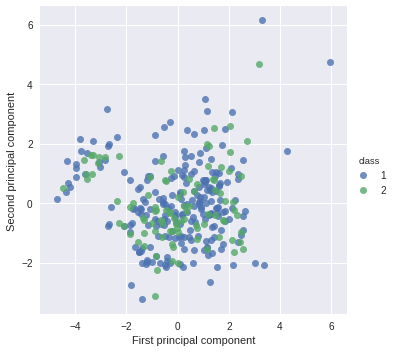

In [15]:
from sklearn.decomposition import PCA

y = data['class of diagnosis']
pca = PCA(n_components=2)
reduced_X = pca.fit_transform(X)
reduced_dfX = pd.DataFrame(reduced_X, columns=['First principal component','Second principal component'])
reduced_dfX['class'] = data['class of diagnosis']
sns.lmplot('First principal component', 'Second principal component', data=reduced_dfX, hue='class', fit_reg=False)



# Logistic Regression

In [16]:
from sklearn.linear_model import LogisticRegression

#np.concatenate((X, np.ones((324,1))), axis=1)
model = LogisticRegression(fit_intercept=False)
model = model.fit(X, y)
model.score
print(data['class of diagnosis'].value_counts())

print(228/(96+228))


1    228
2     96
Name: class of diagnosis, dtype: int64
0.7037037037037037


In [17]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

model2 = LogisticRegression()
model2.fit(X_train, y_train)
predicted = model2.predict(X_test)

In [18]:
print("{}/{} = ".format(np.sum(y_test==predicted), len(y_test)), np.sum(y_test==predicted)/len(y_test))

70/98 =  0.714285714286
